# 0. Introduction
This tutorial is made to introduce Keras at the Machine Learning Study meeting．

The following networks will be examplified:

- Image Processing
  - MLP with MNIST
  - CNN with MNIST
  - CNN with cifiar10
  - autoencoder with MNIST
- Text Processing
  - RNN with binary classification of movie review
  - encoder-decoder (machine translation model)
  - NNLM (language model)
  - Continuous Bag-of-Words
  - Skip Gram

Original Japanese Notebook [github](https://github.com/nzw0301/keras-examples)．

## 0.1 Execution Environment

- Python 3.5.1 (anaconda3-4.0.0)
   - Keras 1.0.2
   - Theano 0.8.2
   - Pydot-ng 1.0.0
   - Gensim 0.12.4
   - Numpy 1.11.0
   - Daft 0.0.4
- OSX (Yosemite)
- GraphViz

If [`pyenv`](https://github.com/yyuu/pyenv) is already installed, run the following command:

`$ pyenv install anaconda3-4.0.0; pip install keras theano gensim pydot-ng git+https://github.com/dfm/daft.git`


## 0.2 Overview

### Features of Keras (from the Official Documentation)
- Modularity
- Minimalism
- Easy extensibility
- Work with Python

### Other Features
- Keras is a popular wrapper for TensorFlow and Theano
- It is hard to describe NN by using TensorFlow and Theano as it is
- In Keras, you can use either as backend
- If you want to use the CNN, it is faster using [TensorFlow]((https://github.com/fchollet/keras/wiki/Keras,-now-running-on-TensorFlow#performance))
- TensorFlow and Theano need to convert variables to dedicated instances, Keras instead does it automatically for you
- Scale of the community is very [large](https://twitter.com/fchollet/status/720639335524007937 )

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

Using Theano backend.


In [2]:
# visualization
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

# 1. MLP with MNIST

- Dataset used: MNIST （handwritten numbers from 0 to 9）
- Model: Multilayer perceptron with one hidden layer

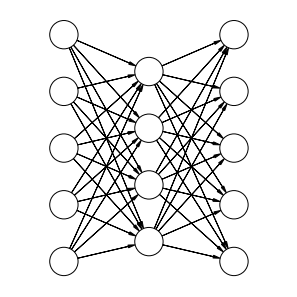

In [3]:
pgm = daft.PGM(shape=[5, 5])

# Nodes
for i in range(5):
    pgm.add_node(daft.Node("x"+str(i), "", 1, i+0.5))

for h in range(4):
    pgm.add_node(daft.Node("h"+str(h), "", 2.5, h+0.85))

for o in range(5):
    pgm.add_node(daft.Node("o"+str(o), "", 4.0, o+0.5))

# Edges
for i in range(5):
    for h in range(4):
        pgm.add_edge("x"+str(i), "h"+str(h))

for h in range(4):
    for o in range(5):
        pgm.add_edge("h"+str(h), "o"+str(o))

        
pgm.render()

## 1.1 Explore and Prepare Data

The MNIST and CIFAR10 datasets are integrated into Keras. Using the Keras pre-defined function 'load_data', the dataset will be downloaded into the datasets directory (`~/.keras/datasets/`) automatically. This avoids download the datasets repeatedly．

In [4]:
# Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10 # class size
input_unit_size = 28*28 # input vector size

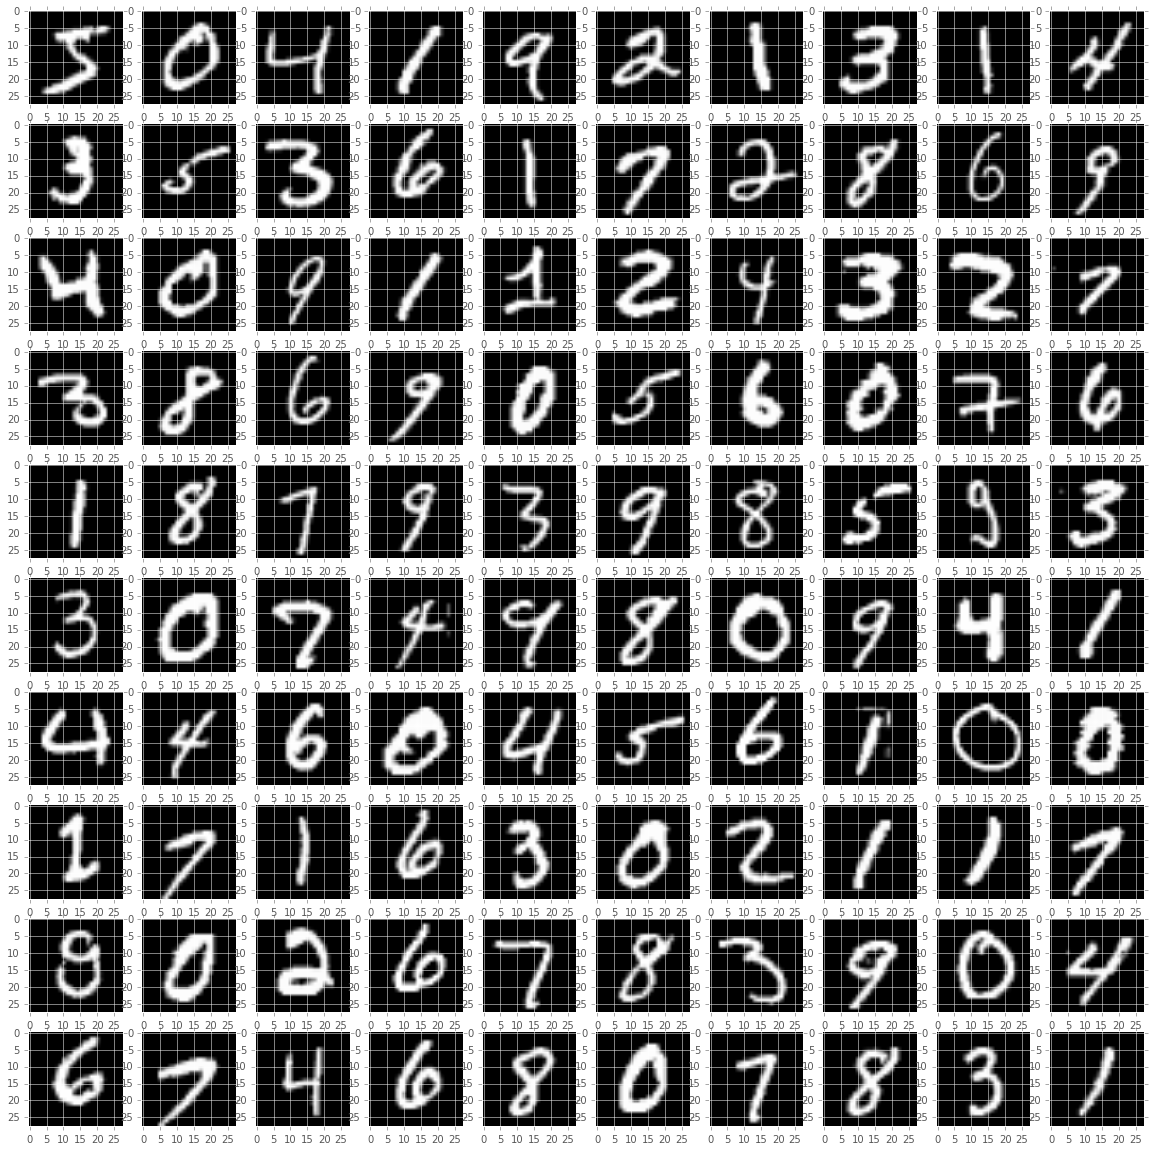

In [5]:
show_size = 10
total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):        
        draw_digit(X_train[total], show_size, show_size, total+1)
        total+=1
plt.show()

In [6]:
# Preprocessing
X_train = X_train.reshape(X_train.shape[0], input_unit_size)
X_test  = X_test.reshape(X_test.shape[0], input_unit_size)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
60000 train samples
10000 test samples


## 1.2 Define Model

In Keras there are 2 ways to define the model:

- `Sequential`: The Sequential model is a linear stack of layers.
- `FunctionalAPI`: The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

The former is sufficient for this MNIST example.

Model definition:
- Input layer: 784 dimensions
- Hidden layer: 128 dimensions
    - Activation function: `reLU` function
    - Dropout rate: 20% of units
- Output layer: 10 dimensions
    - Activation function: `softmax` function 

### 1.2.1 Create `Sequential` Model

- Create `Sequential` model and specify the input shape: the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape.
- Use `add` to define intermediate layers, activation functions and dropouts


In [7]:
model = Sequential()
model.add(Dense(128, input_dim=input_unit_size, init='glorot_uniform'))
model.add(Activation("relu"))
model.add(Dropout(p=0.2))
model.add(Dense(nb_classes, init='glorot_uniform'))
model.add(Activation('softmax'))

### 1.2.2 Create `FunctionalAPI` Model

-  A good use case for the functional API is modeling with multiple inputs and outputs. The functional API makes it easy to manipulate a large number of intertwined datastreams.

In [8]:
# This returns a tensor
inputs = Input(shape=(input_unit_size,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
outputs = Dense(nb_classes, activation="softmax")(x)

# This creates a model that includes
# the Input layer, Dense and Dropout layers
model = Model(input=inputs, output=outputs)

### 1.2.3 Visualize Model

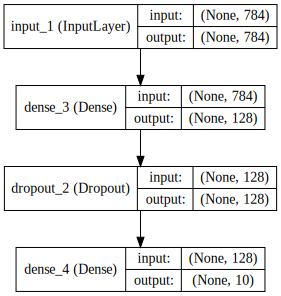

In [9]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 1.3 Choose Optimizer

- An optimizer can be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the Optimizer class. See: [optimizers](https://keras.io/optimizers).
- Using an optimizer class you can define additional parameters e.g. `SGD`. Otherwise default parameters are used. 

In [10]:
optimizer = Adadelta()

## 1.4 Compilation and Training

Compilation with `compile`:
- Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:
- An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. See: [optimizers](https://keras.io/optimizers).
- A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as `categorical_crossentropy` for a multi-class classification problem, `binary_crossentropy` for a binary classification problem or `mse` for a mean squared error regression problem), or it can be an objective custom function. See: [losses](https://keras.io/losses).
- A list of metrics. For any classification problem you will want to set this to `metrics=['accuracy']`. A metric could be the string identifier of an existing metric or a custom metric function.

Training with `fit`:
- Keras models are trained on Numpy arrays of input data and labels using the `fit` function.
- It's much like `fit` function in scikit-learn


In [11]:
# Compilation
# For a single-input multi-class (nb_classes) classification problem
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
nb_epoch = 5

# Train the model, iterating on the data in batches of 256 samples
result = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=256, verbose=2, validation_split=0.2)

# Prediction with test data
score = model.evaluate(X_test, Y_test, batch_size=256)
print("test loss:", score[0])
print("test accu:", score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
1s - loss: 0.4428 - acc: 0.8696 - val_loss: 0.2045 - val_acc: 0.9447
Epoch 2/5
1s - loss: 0.2092 - acc: 0.9401 - val_loss: 0.1505 - val_acc: 0.9560
Epoch 3/5
1s - loss: 0.1609 - acc: 0.9523 - val_loss: 0.1259 - val_acc: 0.9637
Epoch 4/5
1s - loss: 0.1303 - acc: 0.9618 - val_loss: 0.1074 - val_acc: 0.9684
Epoch 5/5
1s - loss: 0.1129 - acc: 0.9676 - val_loss: 0.1000 - val_acc: 0.9706
10000/10000 [==============================] - 0s     
test loss: 0.0920637251928
test accu: 0.9722


## 1.5 Visualization of `loss` and `accuracy` for each epoch

After the training, a `History` object is returned. Besides the parameters of the model, `loss` and `accuracy` metrics for each epoch are recorded.

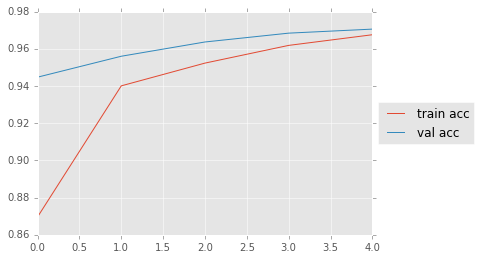

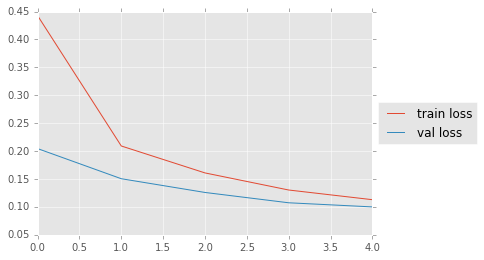

In [12]:
x = range(nb_epoch)
plt.plot(x, result.history['acc'], label="train acc")
plt.plot(x, result.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 1.6 Save and Load Model

A Keras model can be saved as `json` or `yaml` file. The parameters of the trained model is stored in `HDF5` format.

Steps to load a stored model:

1. Load model object from file
2. Read parameters and assign to the model object
3. `compile` the model object


In [13]:
# save model without weights
with open('mnist_model.json', 'w') as f:
    json.dump(model.to_json(), f)
    
model.save_weights('mnist_weights.h5')

[WARNING] mnist_weights.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


In [14]:
# load model
mnist_model = model_from_json(json.load(open("mnist_model.json")))

# load wights
mnist_model.load_weights("./mnist_weights.h5")
mnist_model.compile(loss='categorical_crossentropy', optimizer='adadelta')

## 1.7 Summary

Machine Learning Steps using Keras:
- Evaluate and Prepare Data
- Define a Model
- Compile the Model
- Train the Model!

# 2. CNN with MNIST

The next example uses again the MNIST dataset to demonastrate the CNN technique.

## 2.1 Prepare Data

The input image for the CNN model uses a tensor dimension of $(channels, rows, columns)$.
Since the MNIST dataset is grayscale (1 color channel), it is actually $(1, 28, 28)$．


In [15]:
img_rows, img_cols = 28, 28
nb_classes = 10
nb_filters = 10 # the number of filters
nb_pool = 2 # window size of pooling
nb_conv = 3 # window size of filter

# data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) 
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


## 2.2 Define Model

Same as in MLP, the convolutional and pooling layers can be inserted by the `add` function.

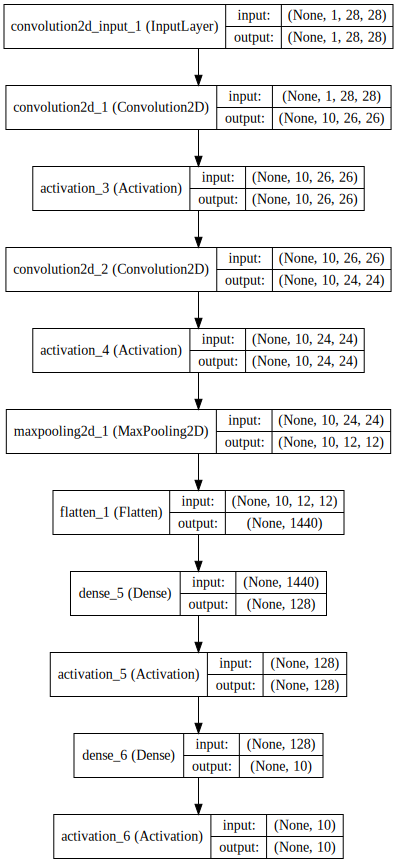

In [16]:
model = Sequential()
model.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 2.3 Train Model

In [17]:
nb_epoch = 5
cnn_result = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=256, verbose=2,  validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
51s - loss: 0.2709 - acc: 0.9140 - val_loss: 0.1108 - val_acc: 0.9650
Epoch 2/5
48s - loss: 0.0687 - acc: 0.9785 - val_loss: 0.0735 - val_acc: 0.9765
Epoch 3/5
47s - loss: 0.0461 - acc: 0.9861 - val_loss: 0.0620 - val_acc: 0.9814
Epoch 4/5
47s - loss: 0.0324 - acc: 0.9902 - val_loss: 0.0593 - val_acc: 0.9840
Epoch 5/5
53s - loss: 0.0233 - acc: 0.9928 - val_loss: 0.0518 - val_acc: 0.9855


## 2.4 Visualization of the learning curve

Let's compare with MLP results. 

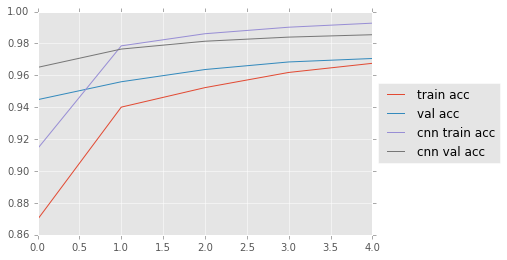

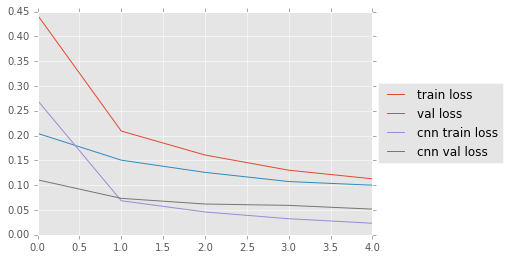

In [22]:
x = range(nb_epoch)
plt.plot(x, result.history['acc'], label="train acc")
plt.plot(x, result.history['val_acc'], label="val acc")
plt.plot(x, cnn_result.history['acc'], label="cnn train acc")
plt.plot(x, cnn_result.history['val_acc'], label="cnn val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.plot(x, cnn_result.history['loss'], label="cnn train loss")
plt.plot(x, cnn_result.history['val_loss'], label="cnn val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2.5 Visualization of the intermediate layers ¶

In Keras, the inputs and outputs of each layer are actually functions. We can visualize their intermediate results as images. 

In [18]:
model.layers

### 2.5.1 Draw the original MNIST training images

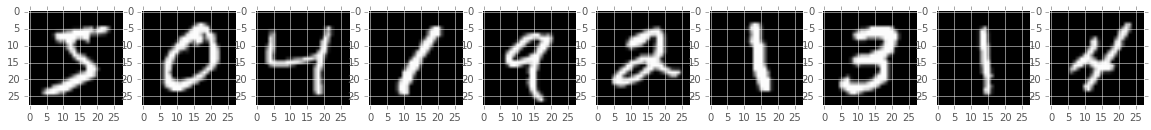

In [19]:
show_size = 10
plt.figure(figsize=(20,20))

for i in range(show_size):
    draw_digit(X_train[i].reshape(28,28), 1, show_size, i+1)
plt.show()

### 2.5.2 Draw result of the first intermediate layer

Visualization of the first convolution layer through a `relu` function.

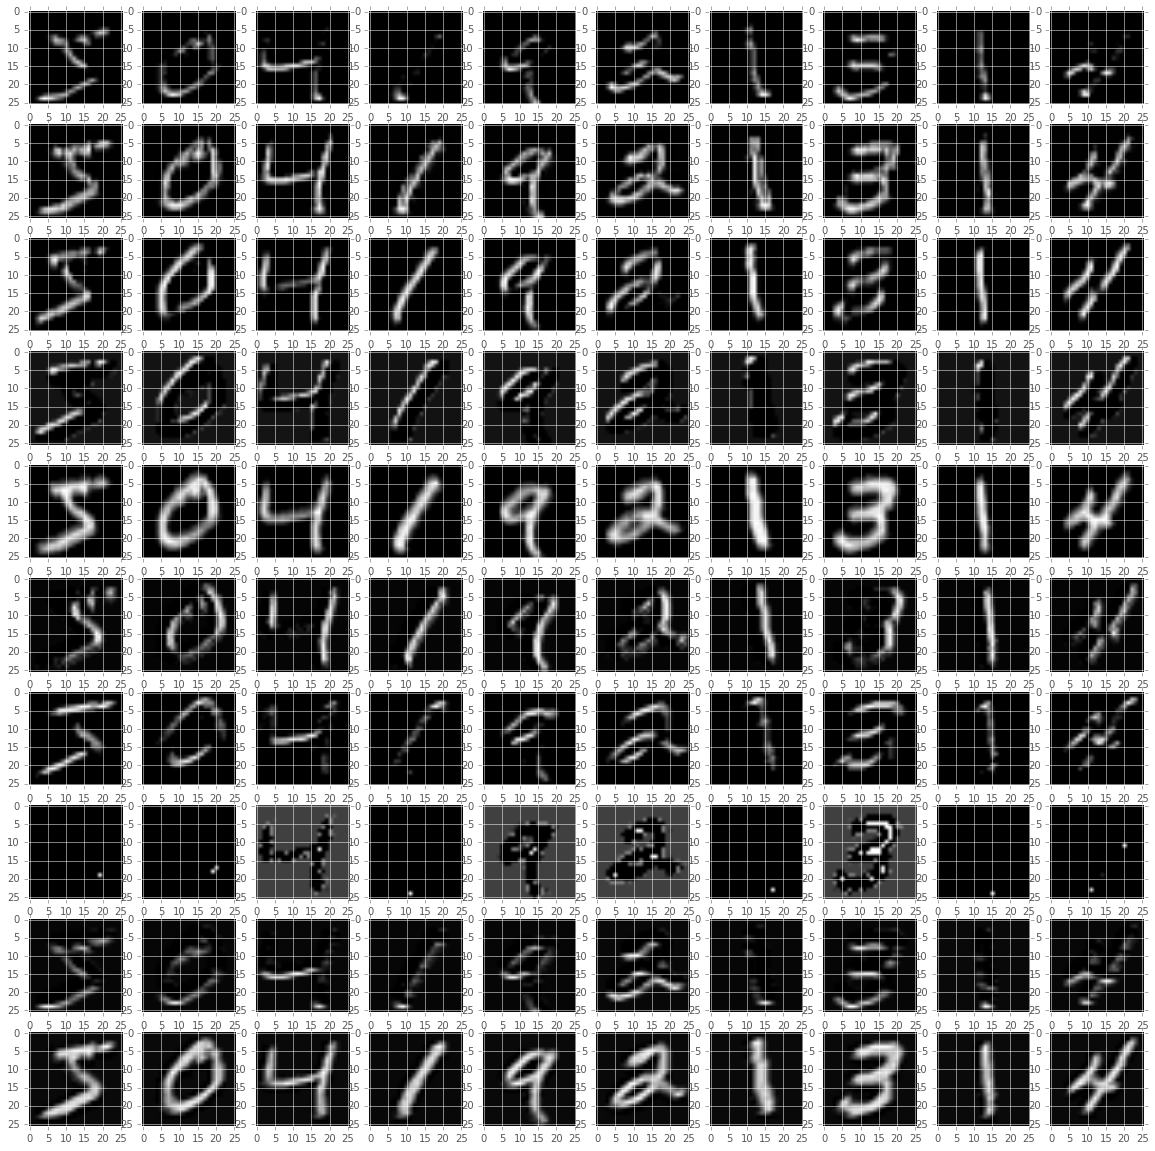

In [23]:
get_first_layer_output = K.function([model.layers[0].input],
                                    [model.layers[1].output])
first_layer = get_first_layer_output([X_train[0:show_size]])[0]

plt.figure(figsize=(20,20))

for img_index, filters in enumerate(first_layer, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

### 2.5.3 Draw result of the second intermediate layer


(10, 10, 24, 24)


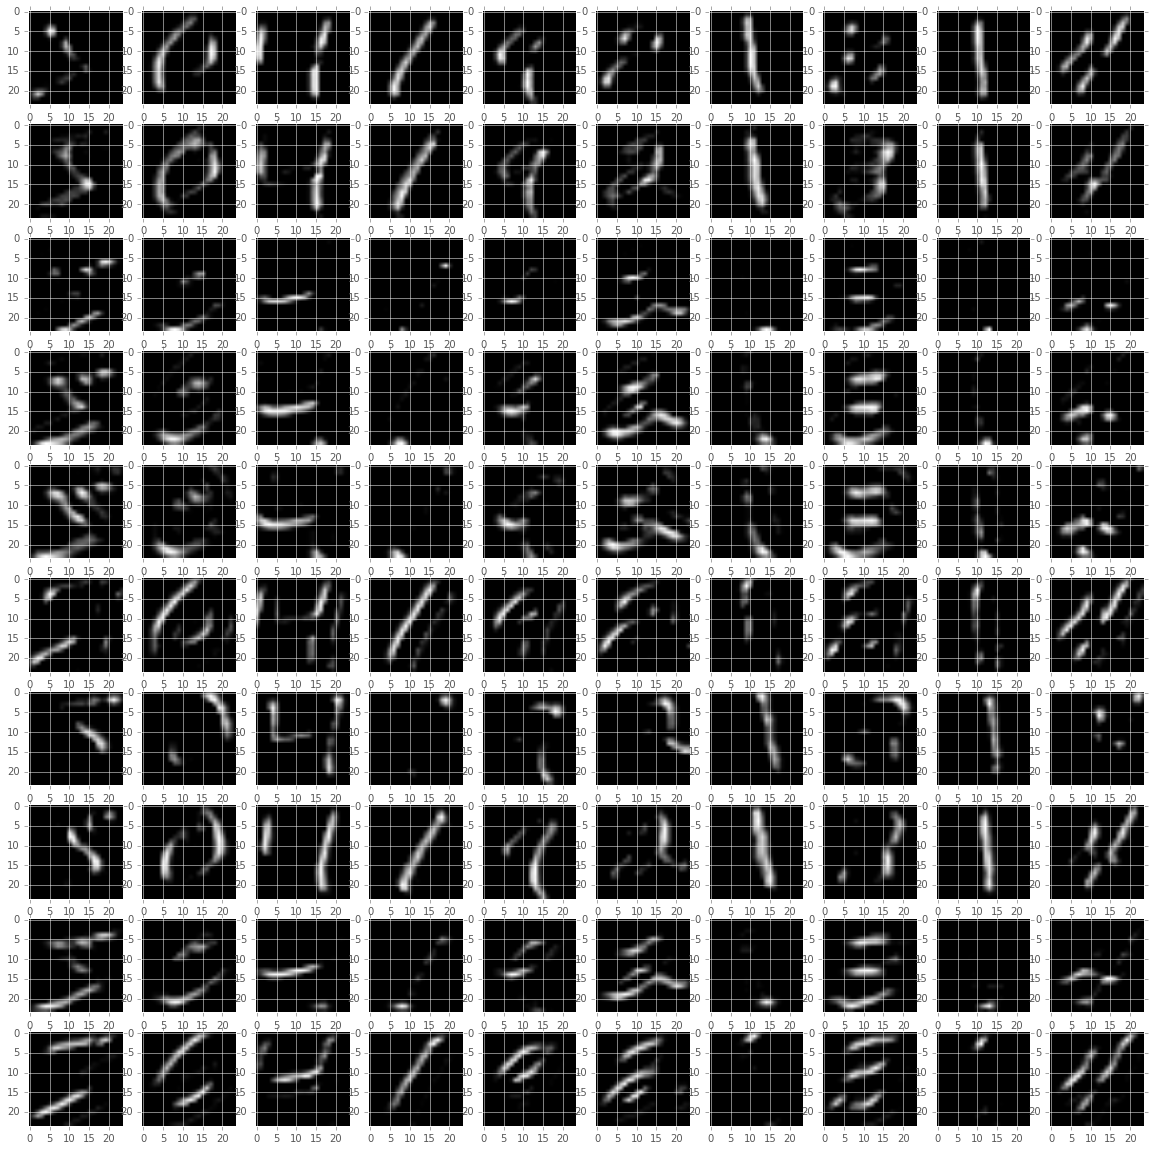

In [20]:
get_second_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
second_output = get_second_layer_output([X_train[0:show_size]])[0]

show_size = 10
plt.figure(figsize=(20,20))
print(second_output.shape)

for img_index, filters in enumerate(second_output, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

### 2.5.4 Draw result after `pooling`

Visualization of the result through the `maxpooling` layer.

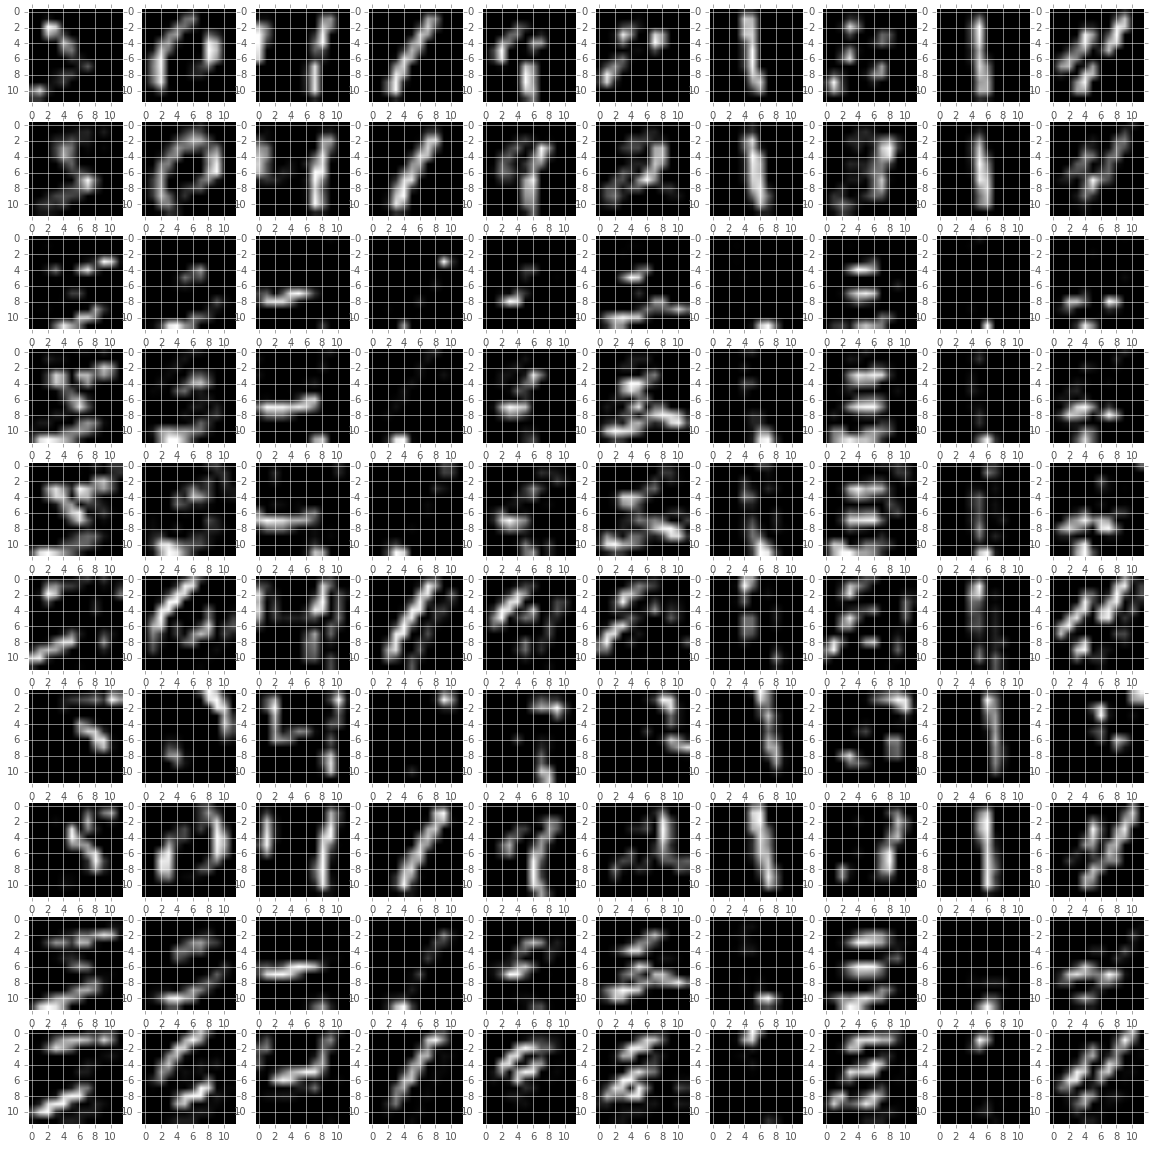

In [24]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])
layers = get_3rd_layer_output([X_train[0:show_size]])[0]

show_size = 10
plt.figure(figsize=(20,20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

# 3. CNN with CIFAR10

In this example we'll experiment with the CIFAR10 color images using CNN. A tensor image has the dimension:
$(channels=3, rows=32, columns=32)$.

## 3.1 Prepare Data

In [25]:
batch_size = 256
nb_classes = 10
nb_epoch = 5
nb_filter = 10

img_rows, img_cols = 32, 32
img_channels = 3

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


## 3.2 Define and Train Model

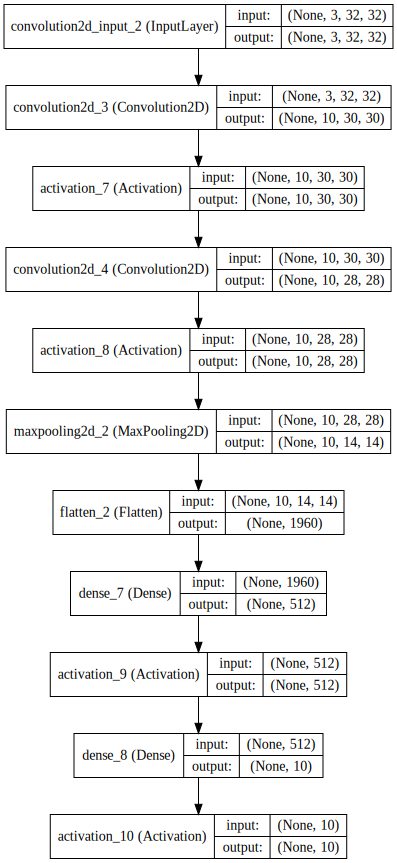

In [26]:
model = Sequential()
model.add(Convolution2D(nb_filter, 3, 3, input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filter, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [27]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 83s - loss: 1.7946 - acc: 0.3630 - val_loss: 1.5176 - val_acc: 0.4663
Epoch 2/5
50000/50000 [==============================] - 82s - loss: 1.3445 - acc: 0.5271 - val_loss: 1.3694 - val_acc: 0.5138
Epoch 3/5
50000/50000 [==============================] - 82s - loss: 1.1380 - acc: 0.6000 - val_loss: 1.2711 - val_acc: 0.5561
Epoch 4/5
50000/50000 [==============================] - 83s - loss: 0.9772 - acc: 0.6598 - val_loss: 1.1615 - val_acc: 0.5963
Epoch 5/5
50000/50000 [==============================] - 82s - loss: 0.8254 - acc: 0.7148 - val_loss: 1.1207 - val_acc: 0.6111


## 3.3 Visualization

In [28]:
# visualization
def draw_color(data, row, col, n):
    plt.subplot(row, col, n)
    plt.imshow(data)

### 3.3.1 Original training images

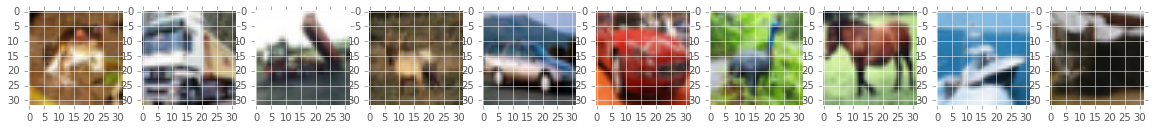

In [29]:
show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
    draw_color(X_train[i].reshape(3, 32, 32).transpose(1, 2, 0), 1, show_size, i+1)
plt.show()

### 3.3.2 c-layer + relu

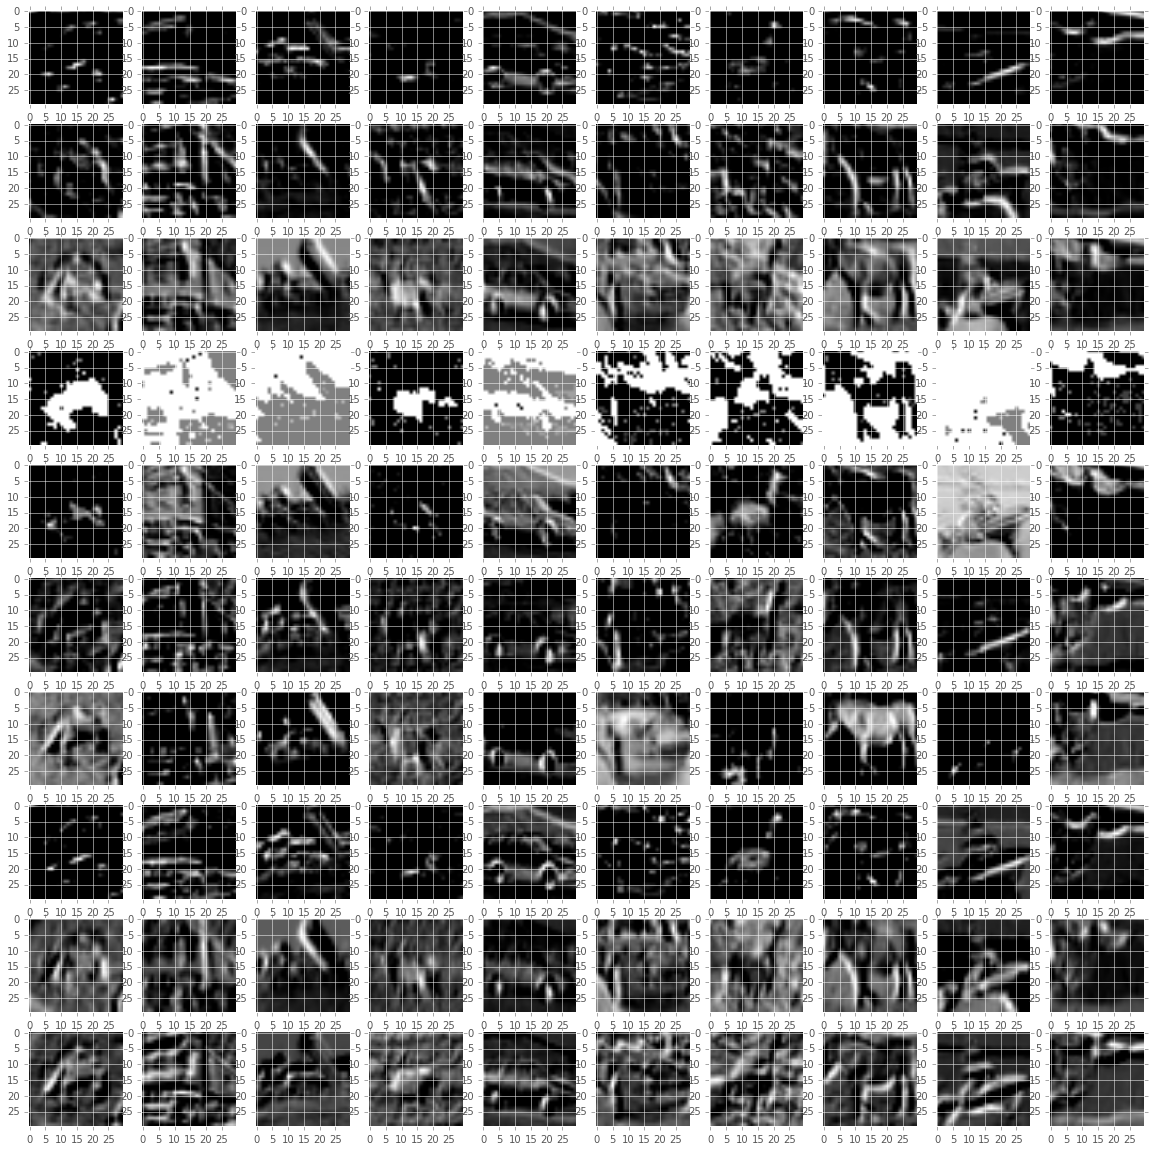

In [30]:
plt.figure(figsize=(20,20))
layer_output = K.function([model.layers[0].input],
                          [model.layers[1].output])
layers = layer_output([X_train[0:show_size]])[0]
for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

### 3.3.3 c-layer + relu + c-layer + relu

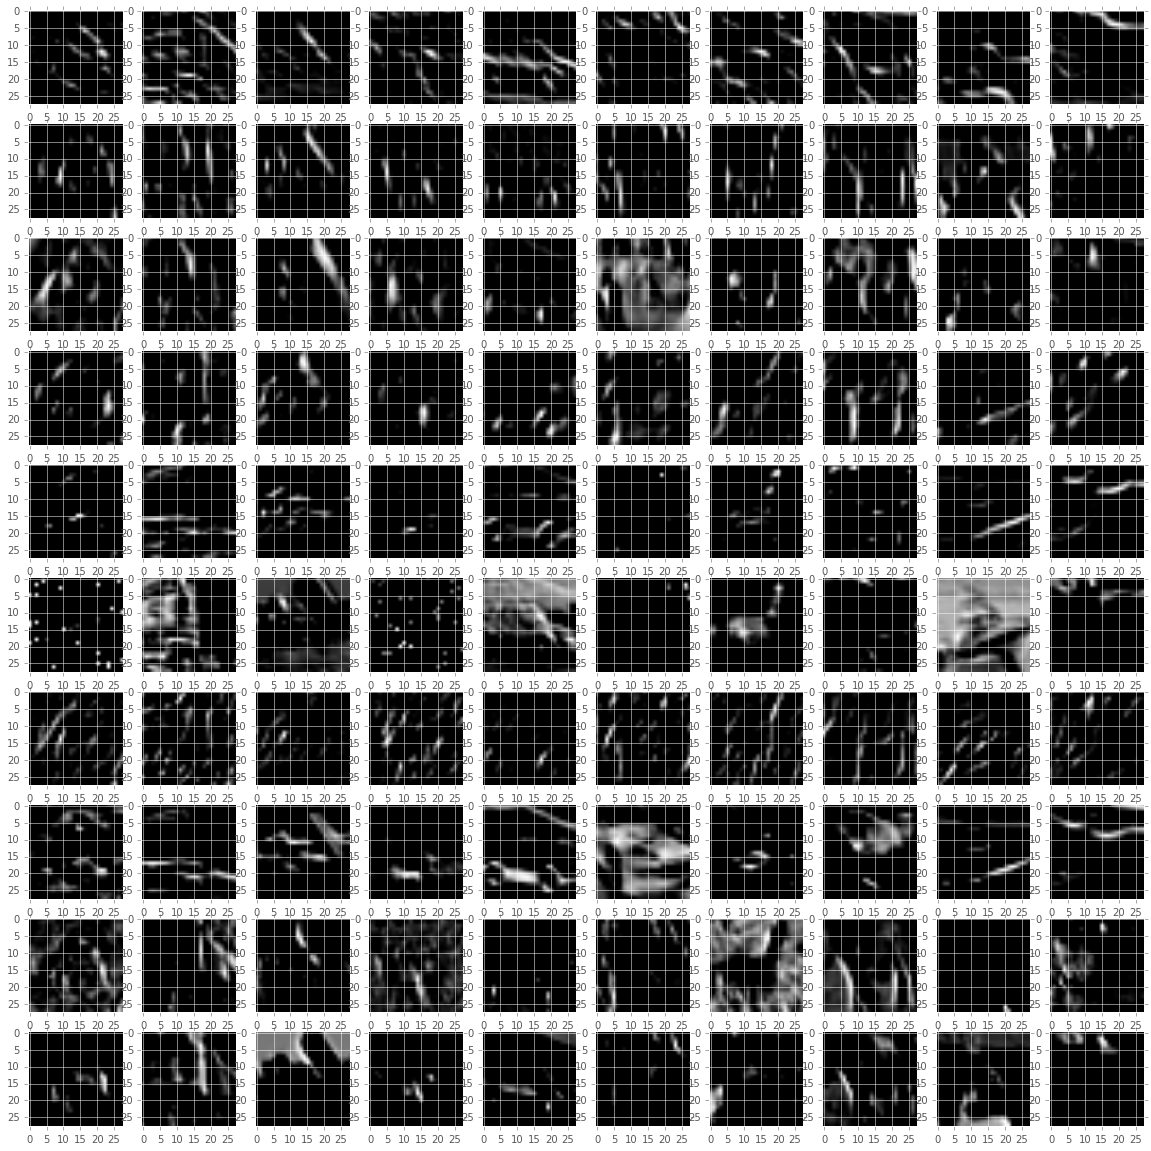

In [31]:
plt.figure(figsize=(20,20))

layer_output = K.function([model.layers[0].input],
                          [model.layers[3].output])

layers = layer_output([X_train[0:show_size]])[0]

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

### 3.3.4 c-layer + relu + c-layer + relu + max-pooling

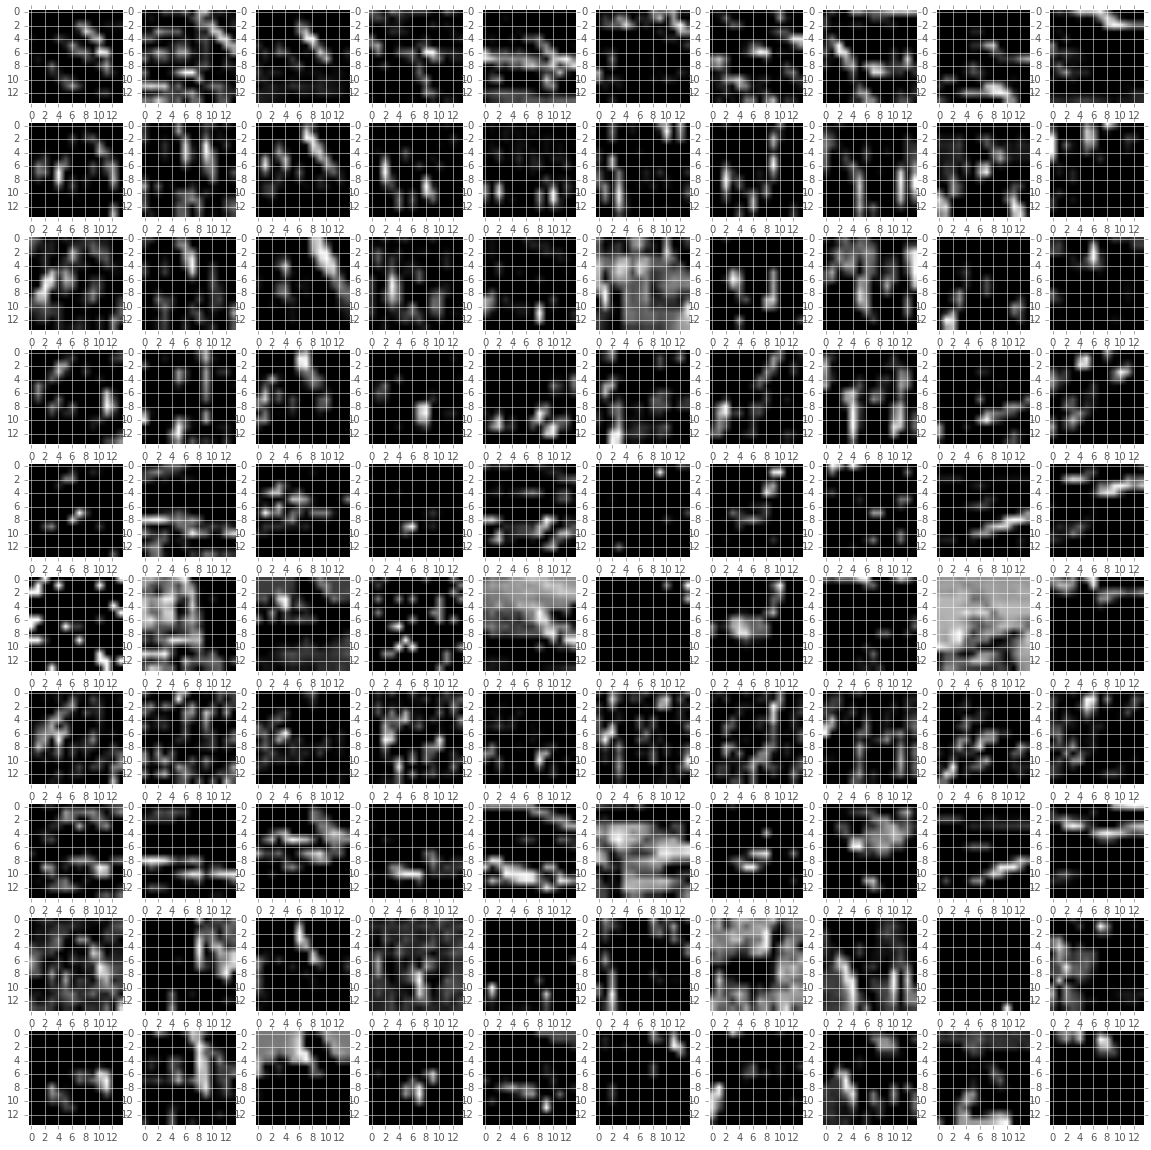

In [32]:
plt.figure(figsize=(20,20))
layer_output = K.function([model.layers[0].input],
                          [model.layers[4].output])
layers = layer_output([X_train[0:show_size]])[0]


for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        mat_size = mat.shape[1]
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

# 4. RNN with binary classification


In language and voice processing we have neural networks with time series data. Techniques such as `Embeddings` and `RNN` can be used here.

## 4.1 Prepare Data

In this example we use movie review data. The input is a serie of words and the output should be 0 or 1 (binary). Each review has a maximum of 140 words and we limit the maximum number of features to 20,000 words. The language preprocessing functions are provided by Keras.

In [33]:
max_features = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
maxlen=140
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
nb_epoch = 3

## 4.2 Define Model

### 4.2.1 Embedding layer

A embedding layer turns positive integers (indexes) into dense vectors of fixed size. e.g. $[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]$ (for example, a word converted to a numerical value). According to the model definition the embedding layer converts each word in the input review sentences (up to 140 words) into a 100 dimensional word vector (`output_dim=100`).
- Input is a 2D tensor with the shape: (batch_size, sequence_length)
- Output is a 3D tensor with the shape: (batch_size, sequence_length, output_dim)

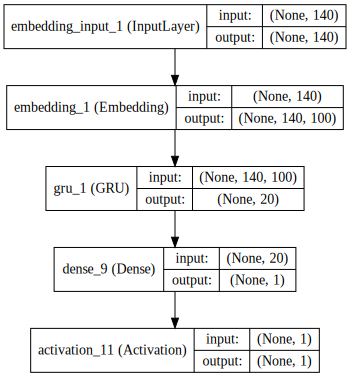

In [34]:
model = Sequential()
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 19999 (vocabulary size).
# now model.output_shape == (None, 140, 100), where None is the batch dimension.
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(GRU(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [35]:
x = X_train[0:2]
print("Inputs shape", x.shape)

embedding_layer = K.function([model.layers[0].input],[model.layers[0].output])
print("Outputs shape", embedding_layer([x])[0].shape)

Inputs shape (2, 140)
Outputs shape (2, 140, 100)


In [36]:
res_gru_1 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch, validation_data=(X_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 41s - loss: 0.6872 - acc: 0.5467 - val_loss: 0.6908 - val_acc: 0.5078
Epoch 2/3
20000/20000 [==============================] - 40s - loss: 0.6574 - acc: 0.6064 - val_loss: 0.6790 - val_acc: 0.5682
Epoch 3/3
20000/20000 [==============================] - 41s - loss: 0.6103 - acc: 0.6783 - val_loss: 0.7436 - val_acc: 0.5790


### 4.2.2 Recurrent Layer

In Keras there're 3 types of `RNN`:
- `SimpleRNN`: Fully-connected RNN where the output is to be fed back to input.
- `GRU`: Gated Recurrent Unit
- `LSTM`: Long-Short Term Memory unit

Input of RNN :
- a 3D tensor with shape $(batch_size, timesteps, input_dim)$ or 
- (optional) 2D tensors with the shape $(batch_size, output_dim)$

Output of RNN:
- if `return_state`: a list of tensors. The first tensor is the output. The remaining tensors are the last states, each with shape $(batch_size, units)$
- if `return_sequences`: 3D tensor with shape $(batch_size, timesteps, units)$
    - If the next layer is also a RNN, you must use `return_sequences=True` to feed the subsequent recurrent layer.
- 2D tensor with shape $(batch_size, units)$

You can set RNN layers to be '`stateful`', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.


### 4.2.3 more RNN

Differences between `GRU` and `LSTM`

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 76s - loss: 0.6862 - acc: 0.5427 - val_loss: 0.6611 - val_acc: 0.6084
Epoch 2/3
20000/20000 [==============================] - 76s - loss: 0.6446 - acc: 0.6205 - val_loss: 0.5929 - val_acc: 0.6686
Epoch 3/3
20000/20000 [==============================] - 75s - loss: 0.5955 - acc: 0.6797 - val_loss: 0.6935 - val_acc: 0.5938


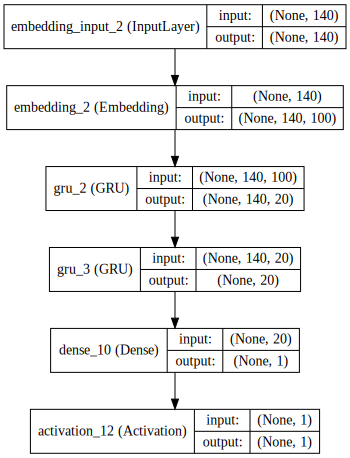

In [37]:
# as the first layer in a Sequential model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(GRU(20, return_sequences=True))
model.add(GRU(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

res_gru_2 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch, validation_data=(X_test, y_test))

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 57s - loss: 0.6841 - acc: 0.5578 - val_loss: 0.6312 - val_acc: 0.6674
Epoch 2/3
20000/20000 [==============================] - 55s - loss: 0.6356 - acc: 0.6504 - val_loss: 0.5661 - val_acc: 0.7092
Epoch 3/3
20000/20000 [==============================] - 57s - loss: 0.5829 - acc: 0.6986 - val_loss: 0.5400 - val_acc: 0.7276


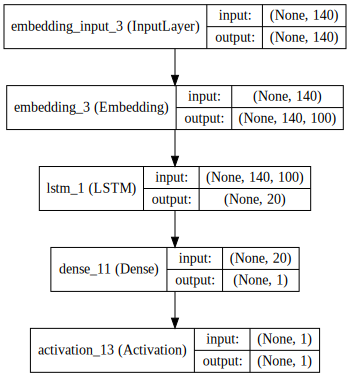

In [38]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

res_lstm_1 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch,
                    validation_data=(X_test, y_test))

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 4.3 Visualization

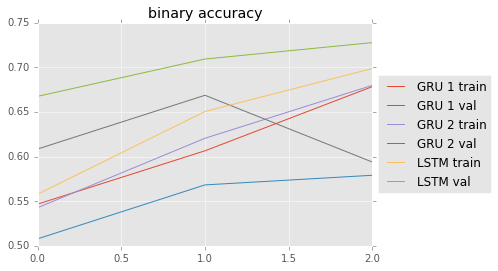

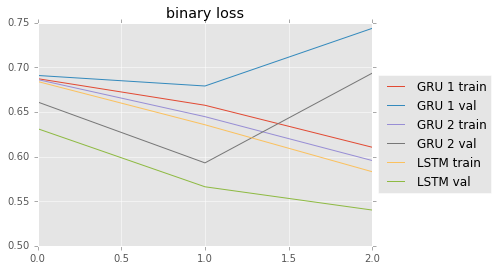

In [39]:
x = range(nb_epoch)
plt.plot(x, res_gru_1.history['acc'], label="GRU 1 train")
plt.plot(x, res_gru_1.history['val_acc'], label="GRU 1 val")
plt.plot(x, res_gru_2.history['acc'], label="GRU 2 train")
plt.plot(x, res_gru_2.history['val_acc'], label="GRU 2 val")
plt.plot(x, res_lstm_1.history['acc'], label="LSTM train")
plt.plot(x, res_lstm_1.history['val_acc'], label="LSTM val")
plt.title("binary accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res_gru_1.history['loss'], label="GRU 1 train")
plt.plot(x, res_gru_1.history['val_loss'], label="GRU 1 val")
plt.plot(x, res_gru_2.history['loss'], label="GRU 2 train")
plt.plot(x, res_gru_2.history['val_loss'], label="GRU 2 val")
plt.plot(x, res_lstm_1.history['loss'], label="LSTM train")
plt.plot(x, res_lstm_1.history['val_loss'], label="LSTM val")
plt.title("binary loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 5. Neural Network Language Models

Markov models predict next words from previous word series．

## 5.1 Dataset

Parts of _Alice's Adventures in Wonderland_ are used as dataset.
- `get_file`: downloads the specified file into the datasets directory `~/.keras/datasets/`
- `Tokenizer`: convenient class to pre-process the text data. A word sequence is converted into a sequence of numeric values (word indexes).


In [40]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
doc = open(path).readlines()[0:50]
tokenizer = Tokenizer()
# trains a list of texts
tokenizer.fit_on_texts(doc)
# list of sequences (one per text input)
doc = tokenizer.texts_to_sequences(doc)
doc = [l for l in doc if len(l) > 1]
words_size = sum([len(words) - 1 for words in doc])

maxlen = max([len(x)-1 for x in doc])
# word_index: dictionary mapping words (str) to their rank/index (int).
vocab_size = len(tokenizer.word_index)+1

## 5.2 Learning in Language Models

Learning to predict the next word from the previous sequence:
1. _alice's_ -> _Adventures_
2. _alice's Adventures_ -> _in_
3.  _alice's Adventures in_ -> _..._

For large datasets, the Python `generator` may have serious memory shortage issues. The best way to fit large data is writing a custom generator in Keras yielding (input sequences, labels) with samples in size of batch and use the `fit_generator` or `train_on_batch` mechanisms.

In [47]:
def generate_data(X, maxlen, V):
    for sentence in X: 
        inputs = []
        targets = []
        for i in range(1, len(sentence)):
            inputs.append(sentence[0:i])
            targets.append(sentence[i])
            y = np_utils.to_categorical(targets, V)
        inputs_sequence = sequence.pad_sequences(inputs, maxlen=maxlen)
        yield (inputs_sequence, y)


## 5.3 Define Model

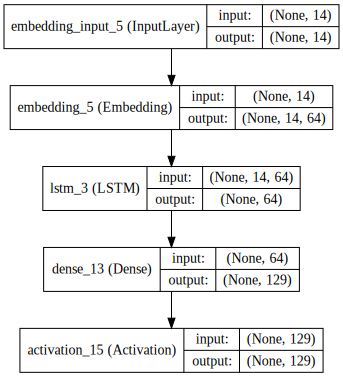

In [48]:
nb_units = 64
model = Sequential()
model.add(Embedding(vocab_size, nb_units, input_length=maxlen))
model.add(LSTM(nb_units, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 5.4 Train and Text Generation

### 5.4.1 Sample Method

For each epoch, a new sentence is added to the words that were predicted. This repeats until the maximum feature length is reached. The `sample` function defines the sampling from a multinomial distribution in accordance with the predicted distribution of words.

In [49]:
def sample(p):
    p /= sum(p)
    return np.where(np.random.multinomial(1,p,1)==1)[1][0]

In [50]:
for i in range(19):
    for x, y in generate_data(doc, maxlen, vocab_size):
        model.train_on_batch(x, y)

    in_words = "alice's"
    for _ in range(maxlen):
        in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
        wordid = sample(model.predict(in_sequence)[0])
        for k, v in tokenizer.word_index.items():
            if v == wordid:
                in_words += " " + k
                break

    print(i, in_words)

0 alice's hot very getting chain pleasure anywhere millennium ebook very 3 a june author cost
1 alice's sister down terms 3 english ebook start very march 'without adventures it the having
2 alice's i the bank alice wonderland in or at included ' 'without hole pleasure 25
3 alice's carroll carroll it hole sitting worth the alice's sleepy or to ' release daisy
4 alice's pictures wonderland ebook ' tired into carroll ' license the edition in she '
5 alice's the her march what carroll and 2011 stupid this worth millennium lewis down adventures
6 alice's 'and use in whether hole of pleasure chapter had alice's or alice 0 sitting
7 alice's for for carroll or what pictures 'without edition adventures a 0 once 1994 hole
8 alice's march carroll rabbit edition very pictures date wonderland would book beginning ﻿project english her
9 alice's her use millennium and mind made worth lewis twice 11 of march could alice's
10 alice's project alice day anyone give carroll carroll is gutenberg's up made

### 5.4.2 Maximum Likelihood Estimation

Text generation based on the maximum likelihood of the connected words.

In [51]:
in_words = "alice's"
for _ in range(maxlen):
    in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
    wordid = model.predict_classes(in_sequence, verbose=0)[0]
    for k, v in tokenizer.word_index.items():
        if v == wordid:
            in_words += " " + k
            break

print(in_words)

alice's adventures in wonderland carroll carroll carroll carroll carroll carroll the of of of of


# 6. Encoder-Decoder

Similar to the previous example, the next model translates Japanese word sequences into English sequences.


## 6.1 Dataset

As input data we use extracts from the book _The Yellow Face_ which provides line-by-line Japanese-English translations. It contains morphological analysis for Japanese already. Beginning and end of a sentence are marked with 'GOS' and 'EOS' respectively to the English sentences.

In [52]:
filters = base_filter() + "「」・。、（）？！　'"

In [58]:
# ja data
ja_docs = open("data/yellow.ja.txt").readlines()[0:50]
ja_tokenizer = Tokenizer(filters=filters)
ja_tokenizer.fit_on_texts(ja_docs)

ja_docs = ja_tokenizer.texts_to_sequences(ja_docs)

# en data
en_docs = open("data/yellow.en.txt").readlines()
en_docs = list(map(lambda x: "GOS " + x + " EOS" , en_docs))[0:50]
en_tokenizer = Tokenizer(filters=filters)
en_tokenizer.fit_on_texts(en_docs)
en_tokenizer.fit_on_texts(en_docs)

en_docs = en_tokenizer.texts_to_sequences(en_docs)

encoder_maxlen = max([len(x) for x in ja_docs])
decoder_maxlen = max([len(x)-1 for x in en_docs])
encoder_vocab_size = len(ja_tokenizer.word_index)+1
decoder_vocab_size = len(en_tokenizer.word_index)+1

## 6.2 Batch Processing and Training Data Generator

In [59]:
def gen_training_data(X, Y, encoder_maxlen, decoder_maxlen, V, samples_size):
    encoder_inputs = []
    decoder_inputs = []
    next_words = []
    for i in range(len(X)):
        x_doc, y_doc = X[i], Y[i]
        for j in range(1, len(y_doc)):
            decoder_inputs.append(y_doc[0:j])
            next_words.append(y_doc[j])
            encoder_inputs.append(x_doc)
            if len(next_words) == samples_size:                
                labels = np_utils.to_categorical(next_words, V)
                encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
                decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)
                yield ([encoder_inputs, decoder_inputs], labels)
                encoder_inputs = []
                decoder_inputs = []
                next_words = []
    labels = np_utils.to_categorical(next_words, V)
    encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
    decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)

    yield ([encoder_inputs, decoder_inputs], labels)

## 6.3 Define Model

The neural network language model is contructed using a combination of encoder and decoder `Sequential`s.


In [60]:
# encoder one doc to one repeated vector
encoder = Sequential()
encoder.add(Embedding(encoder_vocab_size, 128, input_length=encoder_maxlen))
encoder.add(GRU(128, return_sequences=False))
encoder.add(RepeatVector(decoder_maxlen))

# decoder inputs
decoder_input = Sequential()
decoder_input.add(Embedding(decoder_vocab_size, 128, input_length=decoder_maxlen))
decoder_input.add(GRU(output_dim=128, return_sequences=True))
decoder_input.add(TimeDistributed(Dense(128)))

model = Sequential()
model.add(Merge([encoder, decoder_input], mode='concat', concat_axis=-1))
model.add(GRU(128, return_sequences=False))
model.add(Dense(decoder_vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

with open('my_model.json', 'w') as f:
    json.dump(model.to_json(), f)


encoder


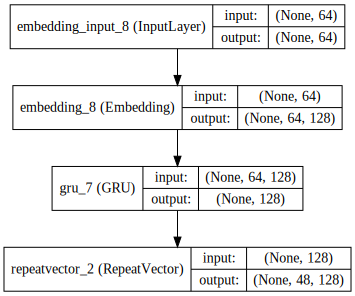

decoder input


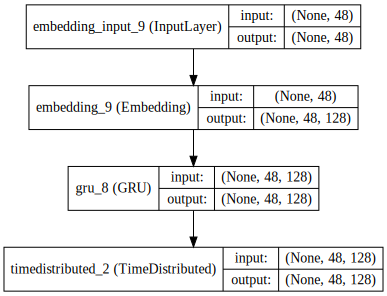

merge and decoder output


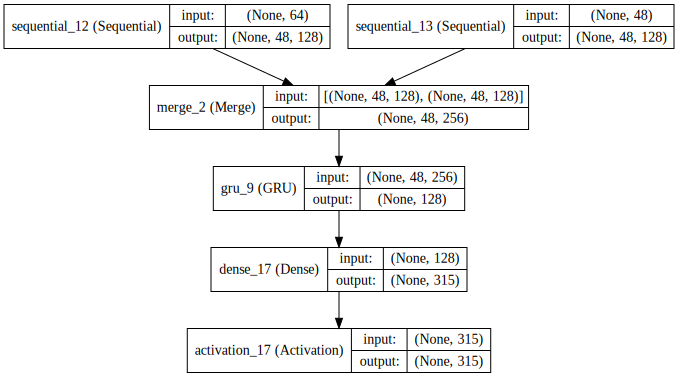

In [61]:
print("encoder")
display(SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg')))
print("decoder input")
display(SVG(model_to_dot(decoder_input, show_shapes=True).create(prog='dot', format='svg')))
print("merge and decoder output")
display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

## 6.4 Training

In [62]:
for i in range(21):
        loss = 0.
        for x, y in gen_training_data(ja_docs, en_docs, encoder_maxlen, decoder_maxlen, decoder_vocab_size, 256):
            loss += model.train_on_batch(x, y)
        print(i, "loss ", loss)
        if not i % 10:
            model.save_weights('my_model_weights_' + str(i) + '.h5')

0 loss  17.2141909599
1 loss  16.9887566566
2 loss  16.2411899567
3 loss  15.7206983566
4 loss  15.5117740631
5 loss  15.4506354332
6 loss  15.4058394432
7 loss  15.3756952286
8 loss  15.34709692
9 loss  15.3168869019
10 loss  15.2805161476
11 loss  15.2358422279
12 loss  15.1841897964
13 loss  15.1340575218
14 loss  15.0821118355
15 loss  15.0178146362
16 loss  14.9242806435
17 loss  14.8268032074
18 loss  14.7436642647
19 loss  14.6707334518
20 loss  14.6044588089


## 6.5 Translation

In [63]:
# load model
model = model_from_json(json.load(open("my_model.json")))

In [64]:
encoder_words = "ホームズ は 答え た"
encoder_in = sequence.pad_sequences(ja_tokenizer.texts_to_sequences([encoder_words]), maxlen=encoder_maxlen)

for i in range(0, 21, 10):
    model.load_weights("./my_model_weights_" + str(i) + ".h5")
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')

    decoder_words = "gos"
    for _ in range(encoder_maxlen):
        decoder_in = sequence.pad_sequences(en_tokenizer.texts_to_sequences([decoder_words]),  maxlen=decoder_maxlen)
        wordid = sample(model.predict([encoder_in, decoder_in])[0])
        
        for k, v in en_tokenizer.word_index.items():
            if v == wordid:
                decoder_words += " " + k
                break
        if k == "eos":
            break

    print(i, decoder_words.replace("gos", "").replace("eos", ""))

0  notes had the did else looks finest these good erred could together save silence gone i strange circumstances the didn watson chanced he breaking capable doyle never his faint relaxed cries habits rather just i kept walks outs importance failures erred forever to breaking ll those into did badly hours passage man versatility beginning gifts burst you for rather strange doyle undoubtedly tale each
10  he holmes elms we in face short no s how sir his 
20  annoying seldom was and as watson and come mouthpieces 


# 7. Autoencoder with MNIST

Using an auto encoder on MNIST handwritten digits.

## 7.1 Prepare Data

In [65]:
input_unit_size = 28*28
# Import MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [66]:
X_train = X_train.reshape(X_train.shape[0], input_unit_size)[0:7000]
X_train = X_train.astype('float32')
X_train /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

X_train shape: (7000, 784)
7000 train samples


## 7.2 Define Model

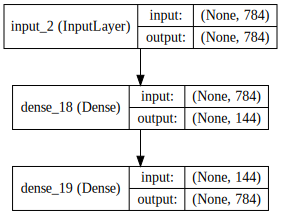

In [67]:
inputs = Input(shape=(input_unit_size,))
x = Dense(144, activation='relu')(inputs)
outputs = Dense(input_unit_size)(x)
model = Model(input=inputs, output=outputs)
model.compile(loss='mse', optimizer='adadelta')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 7.3 Training

In [68]:
model.fit(X_train, X_train, nb_epoch=19, batch_size=256)

Epoch 1/19
7000/7000 [==============================] - 0s - loss: 0.1114     
Epoch 2/19
7000/7000 [==============================] - 0s - loss: 0.0838     
Epoch 3/19
7000/7000 [==============================] - 0s - loss: 0.0688     
Epoch 4/19
7000/7000 [==============================] - 0s - loss: 0.0648     
Epoch 5/19
7000/7000 [==============================] - 0s - loss: 0.0632     
Epoch 6/19
7000/7000 [==============================] - 0s - loss: 0.0620     
Epoch 7/19
7000/7000 [==============================] - 0s - loss: 0.0610     
Epoch 8/19
7000/7000 [==============================] - 0s - loss: 0.0599     
Epoch 9/19
7000/7000 [==============================] - 0s - loss: 0.0589     
Epoch 10/19
7000/7000 [==============================] - 0s - loss: 0.0577     
Epoch 11/19
7000/7000 [==============================] - 0s - loss: 0.0566     
Epoch 12/19
7000/7000 [==============================] - 0s - loss: 0.0554     
Epoch 13/19
7000/7000 [==========================

## 7.4 Visualization
### 7.4.1 Input Images

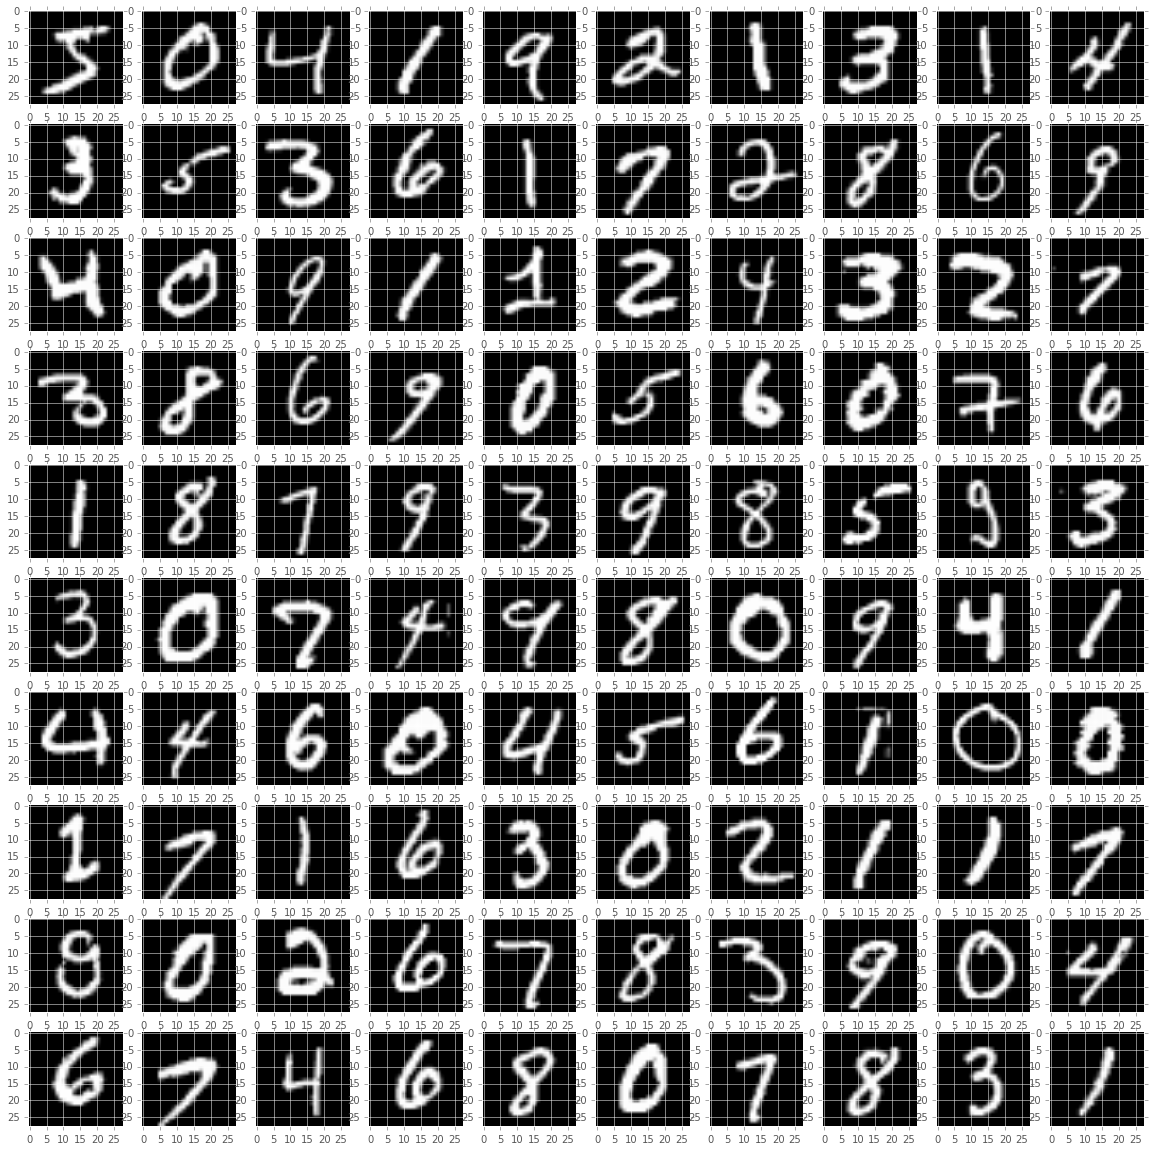

In [69]:
show_size = 10
total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(X_train[total].reshape(28,28), show_size, show_size, total+1)
        total+=1
plt.show()

### 7.4.2 Intermediate Outputs

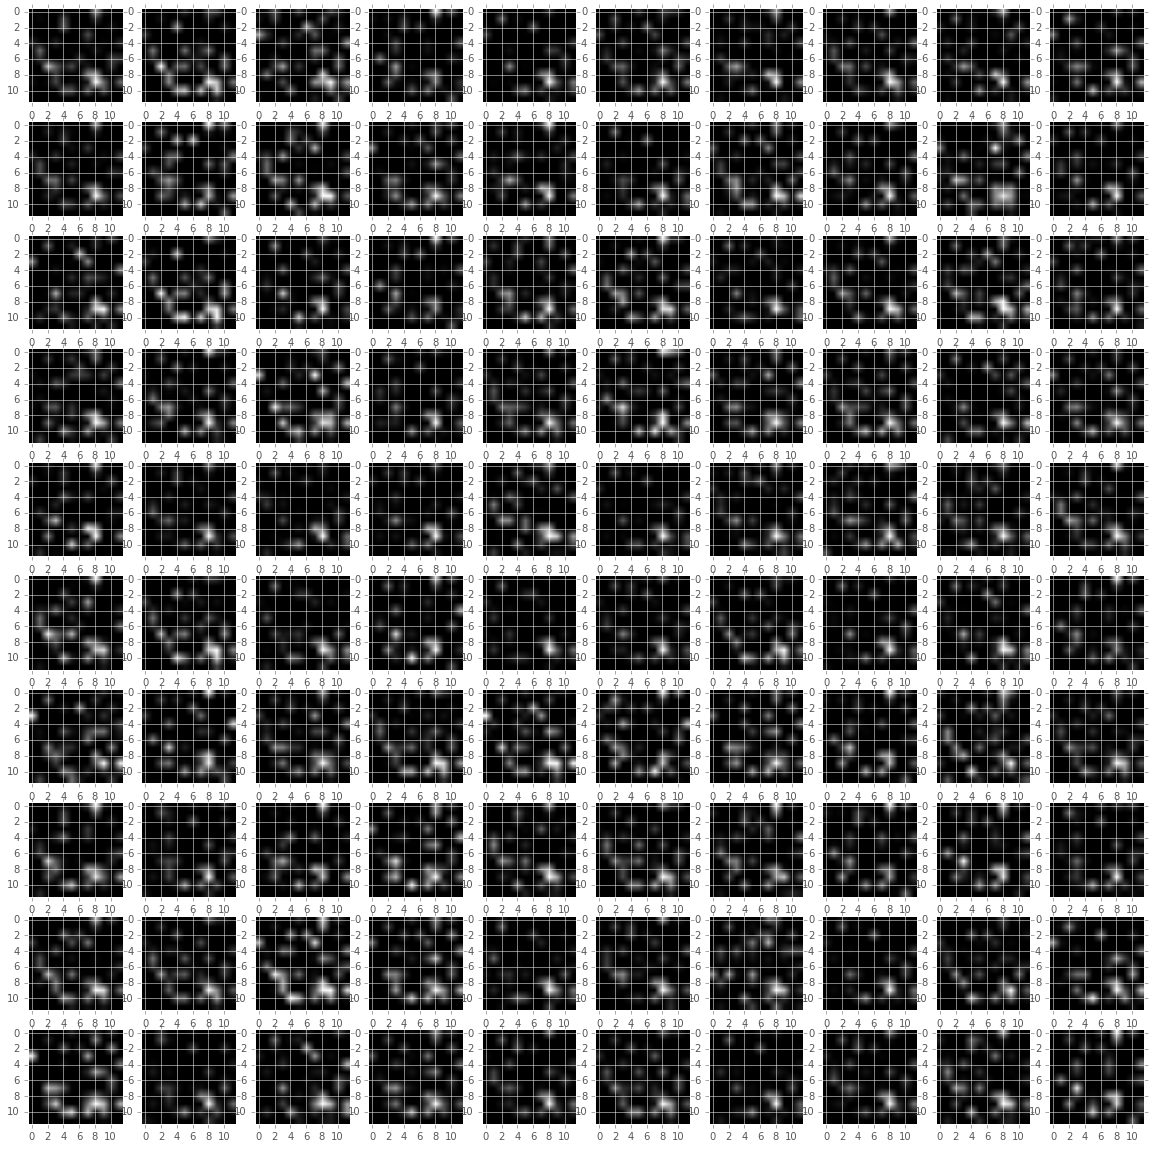

In [70]:
get_layer_output = K.function([model.layers[0].input],
                              [model.layers[1].output])

hidden_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(hidden_outputs[total].reshape(12, 12), show_size, show_size, total+1)
        total+=1
plt.show()

## 7.4.3 Restored Images

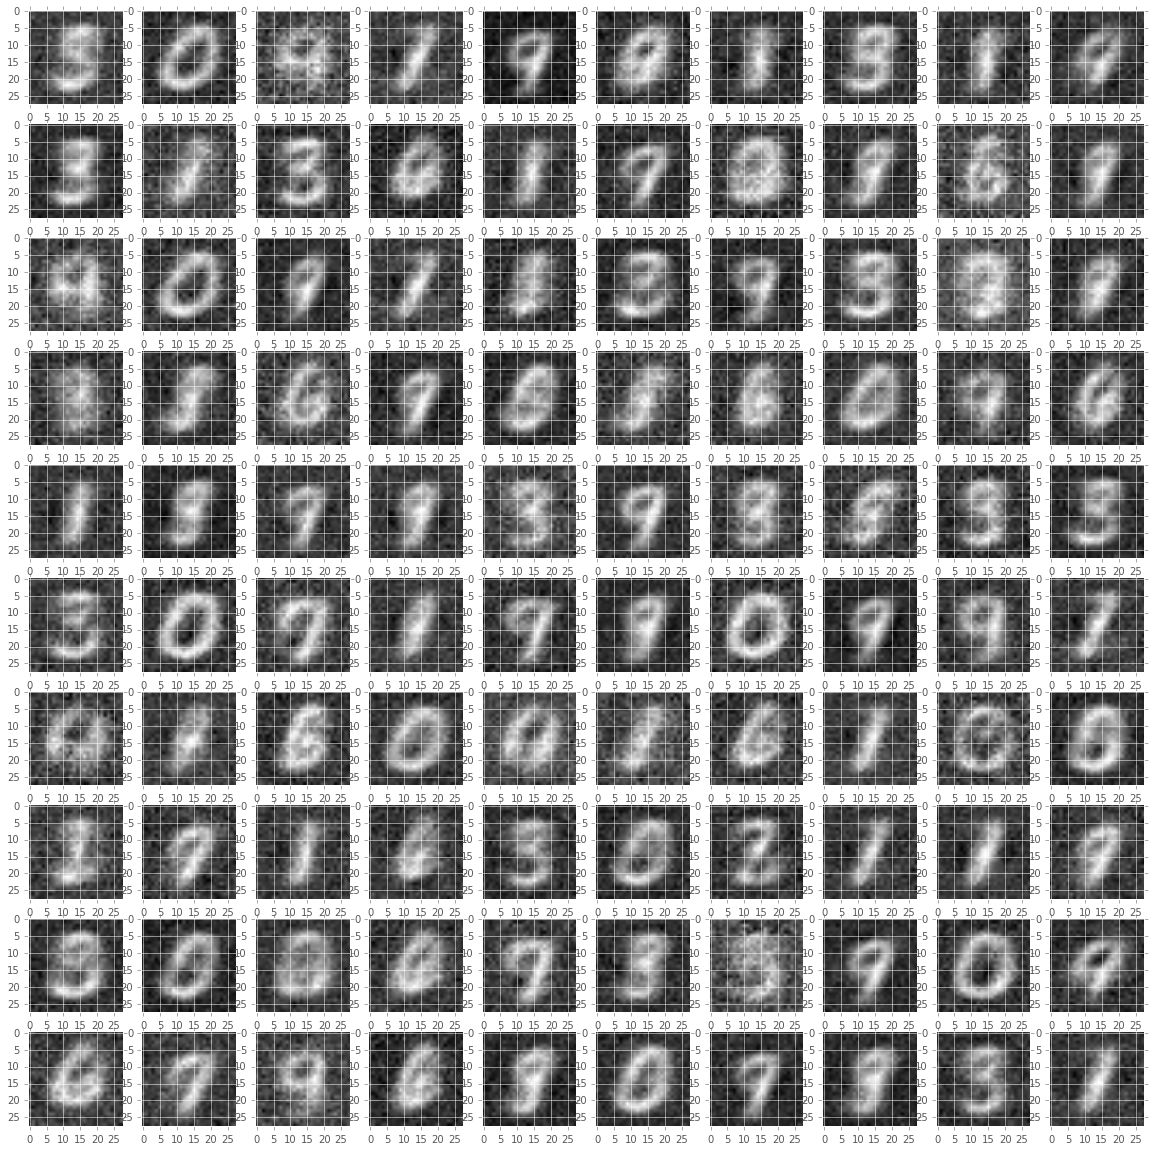

In [71]:
get_layer_output = K.function([model.layers[0].input],
                              [model.layers[2].output])

last_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(last_outputs[total].reshape(28, 28), show_size, show_size, total+1)
        total+=1
plt.show()

# 8. Continuous Bag of Words

Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

A.k.a. Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors:
- Continuous Bag-of-Words model (CBOW)
- Skip-Gram model

Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. 

## 8.1 Dataset

Extractions from _Alice's Adventures in Wonderland_.

In [72]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:500]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
V = len(tokenizer.word_index) + 1 # 語彙数
dim = 100 # ベクトルの次元
window_size = 2 # 文脈窓幅

In [73]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        contexts = []
        labels   = []
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            y = np_utils.to_categorical(labels, V)
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            yield (x, y)
        

## 8.2 Define Model

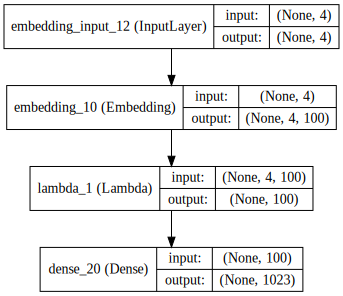

In [74]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

## 8.3 Training

In [75]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

0 28432.1996384
1 24971.1928605
2 23023.7741524
3 21498.2474921
4 20270.641627
5 19247.0622016
6 18333.4240407
7 17502.0578976
8 16770.3190116
9 16126.2936538


## 8.4 Word Vector Storage

`word2vec` stores the word vectors in the same format as the original word vectors.

In [76]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1), str(dim)]))
f.write("\n")

vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

## 8.5 Word Similarity

The example below shows the close words to `alice` using distances between the words.

In [77]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [78]:
w2v.most_similar(positive=['alice'])

[('she', 0.6031362414360046),
 ('mouse', 0.519598126411438),
 ('words', 0.4961796998977661),
 ('come', 0.4896242618560791),
 ('either', 0.46657830476760864),
 ('a', 0.46163544058799744),
 ('we', 0.42980796098709106),
 ('taught', 0.42131510376930237),
 ('burnt', 0.41141557693481445),
 ('and', 0.41073933243751526)]

# 9. Skip Gram

Skip-gram is another famous algorithm in Word2vec. It is a generalization of n-grams in which the components (typically words) need not be consecutive in the text under consideration, but may leave gaps that are skipped over

## 9.1 Dataset

Extractions from _Alice's Adventures in Wonderland_

In [17]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:500]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
V = len(tokenizer.word_index) + 1 # 語彙数
dim = 100 # 100-dimensional vector
window_size = 2 # context window size

In [18]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
                    
            in_words = []
            labels = []
            for i in range(s, e):
                if i != index and 0 <= i < L:
                    in_words.append([word] )
                    labels.append(words[i])

            x = np.array(in_words,dtype=np.int32)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

## 9.2 Define Model

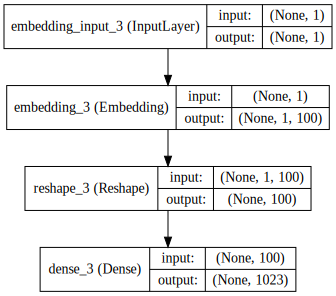

In [19]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, output_dim=V, activation='softmax'))
skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

## 9.3 Training

In [21]:
for ite in range(10):
    print(ite)
    for x, y in generate_data(corpus, window_size, V):
        skipgram.train_on_batch(x, y)

0
1
2
3
4
5
6
7
8
9


## 9.4 Store word vectors and word similarity

In [22]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [23]:
vectors = skipgram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [24]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [36]:
w2v.most_similar(positive=['alice'])

[('begun', 0.3390645384788513),
 ('fallen', 0.33145636320114136),
 ('several', 0.31219980120658875),
 ('bad', 0.3085474371910095),
 ('yes', 0.30289405584335327),
 ('grand', 0.2968328595161438),
 ('anxiously', 0.29533815383911133),
 ('she', 0.29292380809783936),
 ('duck', 0.2897355556488037),
 ('noticed', 0.2748793959617615)]


## 10. Resources

Keras-related resources:
- [Keras Official Website](http://keras.io)
- [Keras Official Blog](http://blog.keras.io/)
- [Keras examples on Github](https://github.com/fchollet/keras/tree/master/examples)
- [Keras Videos on Youtube](https://www.youtube.com/results?search_query=keras+deep+learning)
